In [1]:
%matplotlib inline

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    print("Upload the shapleycomposition.py file")
    from google.colab import files
    files.upload()

In [4]:
if IN_COLAB:
    import sys
    !{sys.executable} -m pip install composition_stats

In [5]:
import os

out_dir = os.path.join('figures', 'ovr_composite')
os.makedirs(out_dir, exist_ok=True)

# Examples of differences between composite Shapley and one-vs-rest Shapley

Composite Shapley

- Unique ordering of feature importance based on the norm of the vectors in the ILR space
- The feature contribution path contains all the information.

Shapley

- One ordering of feature importance per one-vs-rest class Shapley
- Instances with different feature importance paths in the ILR space may show the same Shapley values in the one-vs-rest form

In [6]:
import matplotlib.pyplot as plt
import numpy as np

cm = plt.cm.tab10
colors = cm.colors
cm

plt.rcParams['axes.grid'] = True

# Definition of a coordinate system in ILR space

Isometric Log-ratio space

In [7]:
import numpy as np

def rotate(vector, angle):
    radians = np.radians(angle)
    return np.inner(np.array([[np.cos(radians), -np.sin(radians)],
                              [np.sin(radians), np.cos(radians)]]),
                    np.array(vector).T)

test_list = [np.array([0, 1]), np.array([4, 0]), np.array([2, -7])]
angle_list = [30, 90, -170, -360]
for test in test_list:
    for angle in angle_list:
        rotated_test = rotate(test, angle)
        #print(f"Vector {test} (norm = {np.linalg.norm(test).round(2)}), rotated {angle}° = {rotated_test.round(2)} (norm = {np.linalg.norm(rotated_test).round(2)})")
        np.testing.assert_almost_equal(np.linalg.norm(test), np.linalg.norm(rotated_test))

def plot_ilr_coordinate_system(ax):

    #class_coordinates = np.array([
    #    rotate(np.array([1, 0]), 30),
    #    rotate(np.array([1, 0]), 30+120),
    #    rotate(np.array([1, 0]), 30+240)])

    class_coordinates = np.array([
        rotate(np.array([1, 0]), 30),
        rotate(np.array([1, 0]), 30+120),
        rotate(np.array([1, 0]), 30+240)])
    

    for i, coord in enumerate(class_coordinates):
        ax.arrow(0, 0, coord[0], coord[1], shape='full', head_width=0.1, color=colors[i],
                 linewidth=4)
        ax.text(coord[0]/2, coord[1]/2, f"$C_{i}$")
    
    decision_boundaries = np.array([rotate(np.array([0, 3]), 0),
                           rotate(np.array([0, 3]), 120),
                           rotate(np.array([0, 3]), 240)])
    
    for i, coord in enumerate(decision_boundaries):
        ax.arrow(0, 0, coord[0], coord[1], linestyle='--')
    
    ax.set_box_aspect(1)

Example of the coordinate system

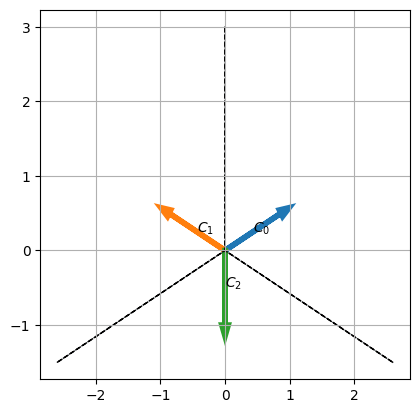

In [8]:
fig = plt.figure()
ax = plt.subplot()
plot_ilr_coordinate_system(ax=ax)

## Definition of instances and the tip of feature contributions in the ILR space

In order to simplify the code, each instance is defined by the end points of the contribution of each feature. This does not correspond to the Shapley values. To obtain the Shapley values we need to subtract the begining of the line of each feature contribution.

In [9]:
base = rotate([0.1, 0], 30)
base = np.array([0 , 0.0])
                
inst_ilr_tip_list = [[rotate([0.5, 0.2], 30),
                  rotate([1, 1], 30),
                  rotate([2, 0], 30)],
                 [rotate([0.5, -0.2], 30),
                  rotate([1, -1], 30),
                  rotate([2, 0], 30)],
                [rotate([2, 0], 30),
                  rotate([2, -0.5], 30),
                  rotate([2, 0], 30)]]

inst_ilr_tip_list = [
#     [np.array([0.2, -0.5]),
#      np.array([1, -1]),
#      np.array([0, -2])],
#     [np.array([0, -2]),
#      np.array([3, -2]),
#      np.array([0, -2])],
     [np.array([-2, -1]),
      np.array([-0.5, -1.5]),
      np.array([0, -2])],
    [np.array([2, 1]),
      np.array([0.5, 1.5]),
      np.array([0, 2])],
     #[np.array([0, -2]),
     # rotate([0, -2], -60),
     # np.array([0, 0])],
     #[rotate([2, 0], 30),
     # np.array([0, 2]),
     # np.array([0, 0])]
]

print("The tip of the contribution of each feature in the ILR space")

inst_ilr_shap_cont_list = [] # Instance ILR shapley contribution list
for i, instance in enumerate(inst_ilr_tip_list):
    print(f"Instance {i}")
    for j in range(len(instance)):
        print(f"\tFeature tip in ILR space of feature {j} = {instance[j].round(2)}")

The tip of the contribution of each feature in the ILR space
Instance 0
	Feature tip in ILR space of feature 0 = [-2 -1]
	Feature tip in ILR space of feature 1 = [-0.5 -1.5]
	Feature tip in ILR space of feature 2 = [ 0 -2]
Instance 1
	Feature tip in ILR space of feature 0 = [2 1]
	Feature tip in ILR space of feature 1 = [0.5 1.5]
	Feature tip in ILR space of feature 2 = [0 2]


## Plot tip of feature contributions in the ILR space

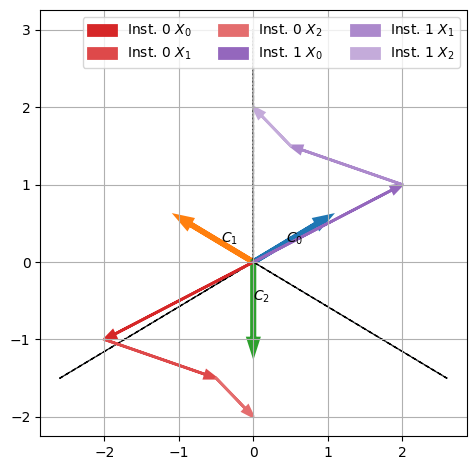

In [10]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def plot_instances(base, inst_ilr_tip_list, ax, head_width=0.1, linestyle='-'):
    instance_colors = colors[3:]

    for i, instance in enumerate(inst_ilr_tip_list):
        last = base.copy()
        color = instance_colors[i]
        for j in range(len(instance)):
            d_next = instance[j] - last
            ax.arrow(x=last[0], y=last[1], dx=d_next[0], dy=d_next[1],
                     shape='full', head_width=head_width, length_includes_head=True,
                     color=adjust_lightness(color, amount=1+0.5*(j/len(instance))),
                     linestyle=linestyle, linewidth=2,
                     label=f"Inst. {i} $X_{j}$")
            last += d_next

fig = plt.figure()
ax = plt.subplot()
plot_ilr_coordinate_system(ax=ax)
plot_instances(base, inst_ilr_tip_list, ax=ax)
plt.legend(ncol=3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f'comp_shap_ilr'), dpi=300, bbox_inches='tight')
plt.show()

## Compute Shapley contribution of each feature in the ILR and space

The shapley contribution of each feature is calculated by subtracting the beginin of each feature to its tip.

In [11]:
from numpy.linalg import norm

inst_ilr_shap_cont_list = [] # Instance ILR shapley contribution list
for i, instance in enumerate(inst_ilr_tip_list):
    inst_ilr_shap_cont_list.append([])
    last = base.copy()
    print(f"Instance {i}")
    for j in range(len(instance)):
        this_contrib = instance[j] - last
        inst_ilr_shap_cont_list[i].append(this_contrib)
        last = instance[j]
        print(f"\tShapley contribution in ILR space of feature {j} = {this_contrib.round(2)}, norm = {norm(this_contrib):0.2}")

Instance 0
	Shapley contribution in ILR space of feature 0 = [-2. -1.], norm = 2.2
	Shapley contribution in ILR space of feature 1 = [ 1.5 -0.5], norm = 1.6
	Shapley contribution in ILR space of feature 2 = [ 0.5 -0.5], norm = 0.71
Instance 1
	Shapley contribution in ILR space of feature 0 = [2. 1.], norm = 2.2
	Shapley contribution in ILR space of feature 1 = [-1.5  0.5], norm = 1.6
	Shapley contribution in ILR space of feature 2 = [-0.5  0.5], norm = 0.71


In [12]:
inst_norm_order_list = [np.argsort([norm(x) for x in shap]) for shap in inst_ilr_shap_cont_list]
print(inst_norm_order_list)

[array([2, 1, 0]), array([2, 1, 0])]


## Feature tips in the ILR and probability space

In [13]:
from composition_stats import ilr, sbp_basis
from shapleycomposition import ilr_inv

sbpmatrix=np.array([[1,-1,0],
                    [1,1,-1]])
basis = sbp_basis(sbpmatrix)

base_prob = ilr_inv(base, basis=basis)
print(f"Base in ILR space = {base}")
print(f"Base probabilities = {base_prob}")
print()


inst_prob_tip_list = []
for i, instance in enumerate(inst_ilr_tip_list):
    print(f"Instance {i}")
    inst_prob_tip_list.append([])
    for j, ilr_feat in enumerate(instance):
        print(f"\tFeature {j} contribution in ILR space = {ilr_feat}")
        prob_feat = ilr_inv(ilr_feat, basis=basis)
        inst_prob_tip_list[-1].append(prob_feat)
        print(f"\t\t\t in probability space = {prob_feat.round(2)}")
    print()

Base in ILR space = [0. 0.]
Base probabilities = [0.33333333 0.33333333 0.33333333]

Instance 0
	Feature 0 contribution in ILR space = [-2 -1]
			 in probability space = [0.03 0.53 0.44]
	Feature 1 contribution in ILR space = [-0.5 -1.5]
			 in probability space = [0.08 0.17 0.75]
	Feature 2 contribution in ILR space = [ 0 -2]
			 in probability space = [0.07 0.07 0.85]

Instance 1
	Feature 0 contribution in ILR space = [2 1]
			 in probability space = [0.88 0.05 0.06]
	Feature 1 contribution in ILR space = [0.5 1.5]
			 in probability space = [0.62 0.31 0.07]
	Feature 2 contribution in ILR space = [0 2]
			 in probability space = [0.48 0.48 0.04]



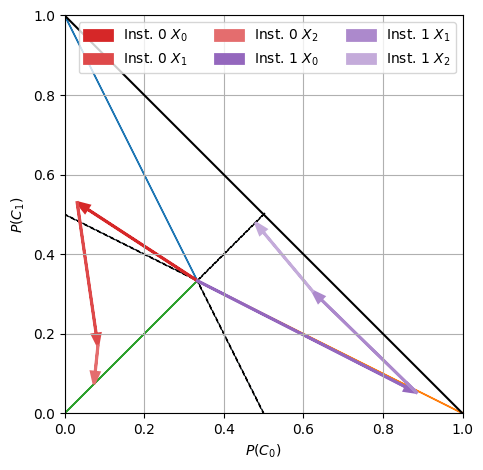

In [14]:
def plot_instances_probability(base_prob, inst_prob_tip_list, ax):
    skip_last_dim = []
    for instance in inst_prob_tip_list:
        skip_last_dim.append([row[:-1] for row in instance])
        
    return plot_instances(base_prob[:-1], skip_last_dim, ax, head_width=0.02, linestyle='-')

def plot_prob_coordinate_system(ax):
    class_coordinates = np.array([[0, 1],
                                 [1, 0],
                                 [0, 0]])
    

    for i, coord in enumerate(class_coordinates):
        ax.arrow(1/3, 1/3, coord[0]-1/3, coord[1]-1/3, shape='full', head_width=0.02, color=colors[i])
    
    decision_boundaries = np.array([[0, 0.5],
                                    [0.5, 0],
                                    [0.5, 0.5]])
    
    for i, coord in enumerate(decision_boundaries):
        ax.arrow(1/3, 1/3, coord[0]-1/3, coord[1]-1/3, linestyle='--')
    
    ax.set_box_aspect(1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('$P(C_0)$')
    ax.set_ylabel('$P(C_1)$')
    ax.add_line(plt.Line2D([0, 1], [1, 0], color='k'))
    ax.set_aspect('equal')
    


fig = plt.figure()
ax = plt.subplot()
plot_prob_coordinate_system(ax)
plot_instances_probability(base_prob, inst_prob_tip_list, ax=ax);
plt.legend(ncol=3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f'comp_shap_prob'), dpi=300, bbox_inches='tight')
plt.show()

## Feature contributions in ILR and probability space

In [15]:
sbpmatrix=np.array([[1,-1,0],
                    [1,1,-1]])
basis = sbp_basis(sbpmatrix)

base_prob = ilr_inv(base, basis=basis)
print(f"Base in ILR space = {base}")
print(f"Base probabilities = {base_prob}")
print()


inst_prob_shap_cont_list = []
for i, instance in enumerate(inst_ilr_shap_cont_list):
    print(f"Instance {i}")
    inst_prob_shap_cont_list.append([])
    for j, ilr_feat in enumerate(instance):
        print(f"\tFeature {j} contribution in ILR space = {ilr_feat}")
        prob_feat = ilr_inv(ilr_feat, basis=basis)
        inst_prob_shap_cont_list[-1].append(prob_feat)
        print(f"\t\t\t in probability space = {prob_feat.round(2)}")
    print()

Base in ILR space = [0. 0.]
Base probabilities = [0.33333333 0.33333333 0.33333333]

Instance 0
	Feature 0 contribution in ILR space = [-2. -1.]
			 in probability space = [0.03 0.53 0.44]
	Feature 1 contribution in ILR space = [ 1.5 -0.5]
			 in probability space = [0.57 0.07 0.36]
	Feature 2 contribution in ILR space = [ 0.5 -0.5]
			 in probability space = [0.36 0.18 0.46]

Instance 1
	Feature 0 contribution in ILR space = [2. 1.]
			 in probability space = [0.88 0.05 0.06]
	Feature 1 contribution in ILR space = [-1.5  0.5]
			 in probability space = [0.09 0.76 0.14]
	Feature 2 contribution in ILR space = [-0.5  0.5]
			 in probability space = [0.26 0.53 0.2 ]



Instance 0
	Feature 0 Shapley probability contribution = [0.03 0.53 0.44]
	Feature 1 Shapley probability contribution = [0.57 0.07 0.36]
	Feature 2 Shapley probability contribution = [0.36 0.18 0.46]
Instance 1
	Feature 0 Shapley probability contribution = [0.88 0.05 0.06]
	Feature 1 Shapley probability contribution = [0.09 0.76 0.14]
	Feature 2 Shapley probability contribution = [0.26 0.53 0.2 ]


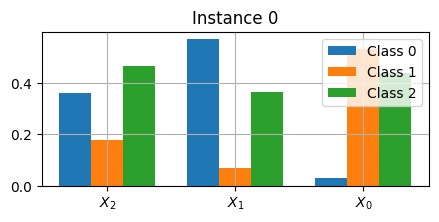

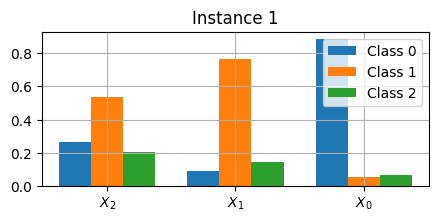

In [16]:
for i, shapley_prob_list in enumerate(inst_prob_shap_cont_list):
    print(f"Instance {i}")
    for j, shapley_prob in enumerate(shapley_prob_list):
        print(f"\tFeature {j} Shapley probability contribution = {shapley_prob.round(2)}")

def plot_shapley_instances_bars(inst_prob_shap_cont_list, feat_names=None, order_list=None):
    fig_list = []
    for i, shapley_prob_list in enumerate(inst_prob_shap_cont_list):
        fig = plt.figure(figsize=(5, 2))
        fig_list.append(fig)
        ax = fig.add_subplot()
        ax.set_title(f"Instance {i}")
        n_features = len(shapley_prob_list)
        x = np.arange(n_features)
        n_classes = len(shapley_prob_list[0])
        width = 1/(n_classes+1)
        shapley_prob_list_t = np.array(shapley_prob_list).T
        if order_list is not None:
            shapley_prob_list_t = shapley_prob_list_t.T[order_list[i]].T
        for j, shapley_prob in enumerate(shapley_prob_list_t):
            offset = width * j
            ax.bar(x + offset, shapley_prob, width, label=f"Class {j}")
        if feat_names is None:
            feat_names_instance = np.array([f"$X_{j}$" for j in range(n_features)])
        else:
            feat_names_instance = np.array(feat_names)
        if order_list is not None:
            feat_names_instance = feat_names_instance[order_list[i]]
        ax.set_xticks(x + width, feat_names_instance)
        ax.legend()
    plt.show()
    return fig_list

fig_list = plot_shapley_instances_bars(inst_prob_shap_cont_list, order_list=inst_norm_order_list)
for i, fig in enumerate(fig_list):
    fig.savefig(os.path.join(out_dir, f'comp_shap_inst_{i}'), dpi=300, bbox_inches='tight')

## One-vs-rest SHAP contributions

**TODO:** Need to add the feature contributions projected into each class

In [17]:
inst_ovr_prob_shap_cont_list = [] # Instance ILR shapley contribution list
for i, instance in enumerate(inst_ilr_tip_list):
    inst_ovr_prob_shap_cont_list.append([])
    last = ilr_inv(base.copy(), basis=basis)
    print(f"Instance {i}")
    for j in range(len(instance)):
        this_contrib = ilr_inv(instance[j], basis=basis) - last
        inst_ovr_prob_shap_cont_list[i].append(this_contrib)
        last = ilr_inv(instance[j], basis=basis)
        print(f"\tOne vs Rest Shapley contribution in probability space of feature {j} = {this_contrib.round(2)}")

Instance 0
	One vs Rest Shapley contribution in probability space of feature 0 = [-0.3   0.2   0.11]
	One vs Rest Shapley contribution in probability space of feature 1 = [ 0.05 -0.36  0.31]
	One vs Rest Shapley contribution in probability space of feature 2 = [-0.01 -0.1   0.11]
Instance 1
	One vs Rest Shapley contribution in probability space of feature 0 = [ 0.55 -0.28 -0.27]
	One vs Rest Shapley contribution in probability space of feature 1 = [-0.26  0.25  0.01]
	One vs Rest Shapley contribution in probability space of feature 2 = [-0.14  0.17 -0.03]


Instance 0
Class 0 vs rest
Shapley values for this class = [-0.3020025   0.05221609 -0.00992241]


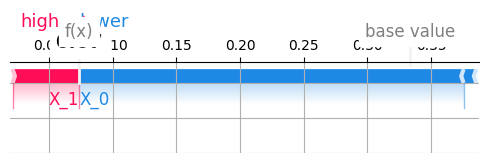

Class 1 vs rest
Shapley values for this class = [ 0.1967476  -0.36063819 -0.09581825]


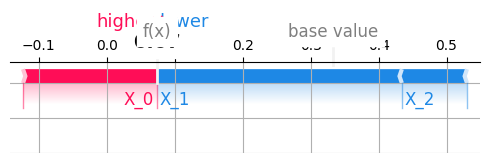

Class 2 vs rest
Shapley values for this class = [0.1052549  0.3084221  0.10574066]


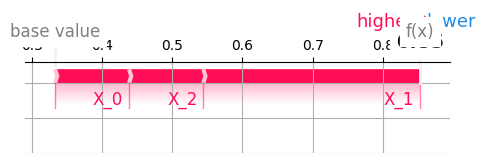

Instance 1
Class 0 vs rest
Shapley values for this class = [ 0.55119864 -0.26144423 -0.14377894]


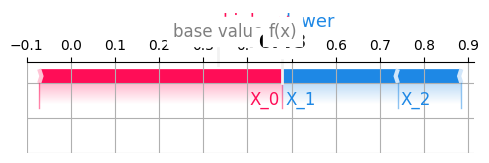

Class 1 vs rest
Shapley values for this class = [-0.28105241  0.25494414  0.17208375]


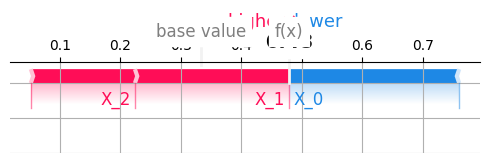

Class 2 vs rest
Shapley values for this class = [-0.27014623  0.0065001  -0.02830481]


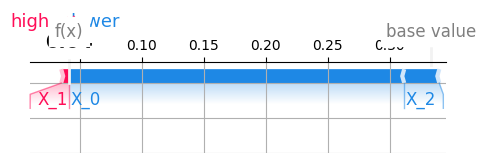

In [18]:
import shap

for i, instance in enumerate(inst_ovr_prob_shap_cont_list):
    print(f"Instance {i}")
    for label_id in range(3):
        print(f"Class {label_id} vs rest")
        feat_class_m = np.array(instance)
        print(f"Shapley values for this class = {feat_class_m[:,label_id]}")
        shap.force_plot(
            base_value=base_prob[label_id],
            shap_values=feat_class_m[:,label_id],
            features=[f"X_{j}" for j in range(feat_class_m.shape[1])],
            matplotlib=True, show=False,
            figsize=(5, 2)
        )
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f'ovr_shap_inst_{i}_class_{label_id}'), dpi=300, bbox_inches='tight')
        plt.show()

## Changes in probability ordered by feature id

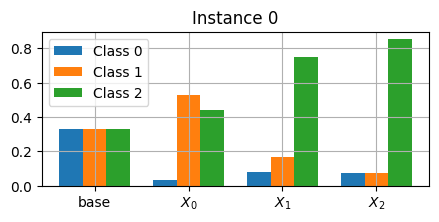

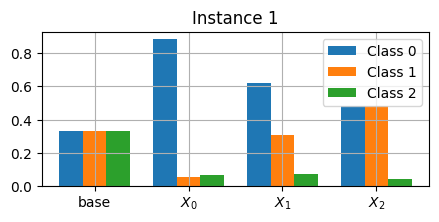

In [19]:
inst_prob_tip_with_base_list = [[base_prob, ] + inst_list for inst_list in inst_prob_tip_list]

fig_list = plot_shapley_instances_bars(inst_prob_tip_with_base_list,
                                       feat_names=['base', ] + [f"$X_{j}$" for j in range(len(inst_prob_tip_list[0]))])
for i, fig in enumerate(fig_list):
    fig.savefig(os.path.join(out_dir, f'comp_shap_cum_inst_{i}'), dpi=300, bbox_inches='tight')

## Changes in probability ordered by feature norm in ILR space

**TODO** The following cell needs to be fixed

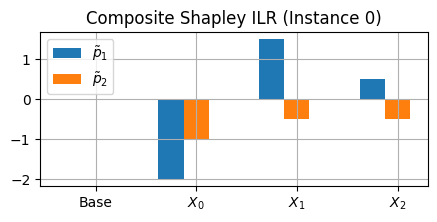

[2 1 0]


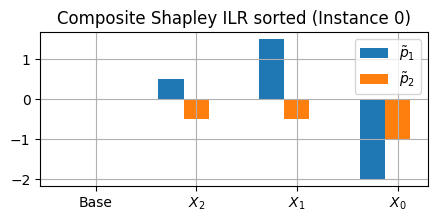

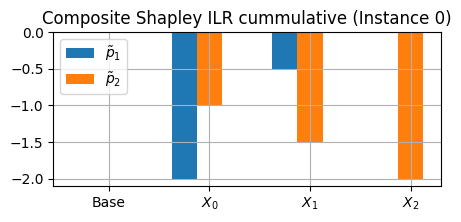

[2 1 0]


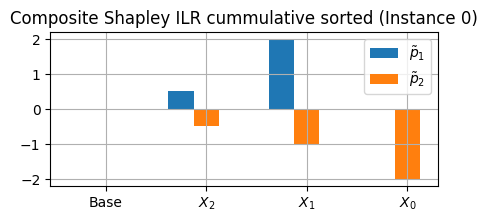

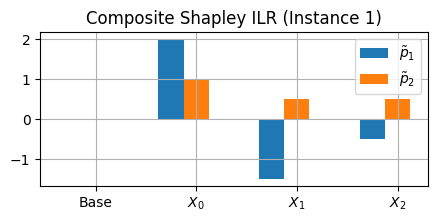

[2 1 0]


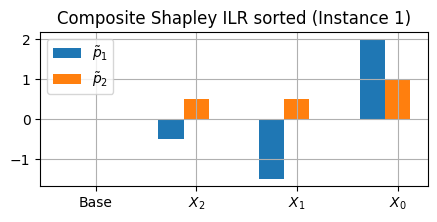

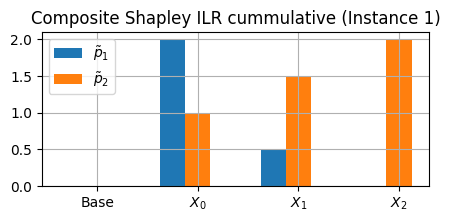

[2 1 0]


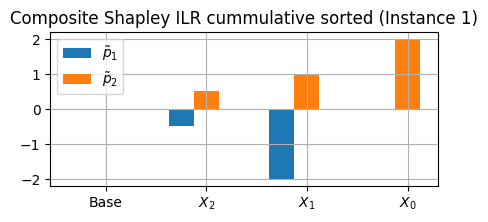

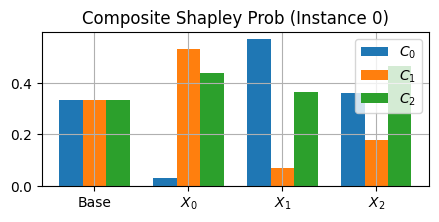

[2 1 0]


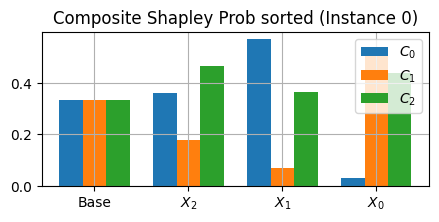

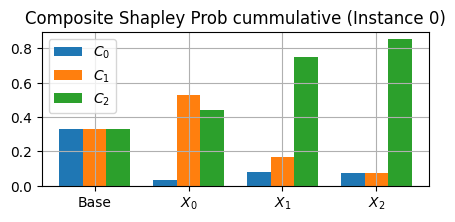

[2 1 0]


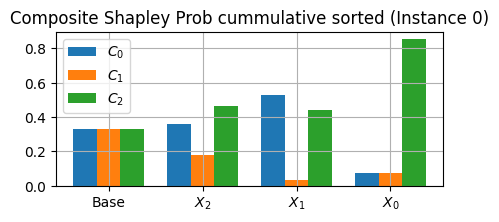

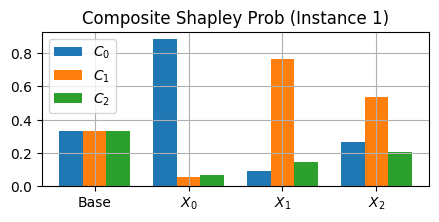

[2 1 0]


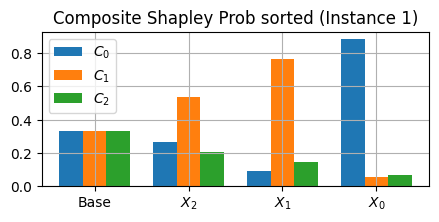

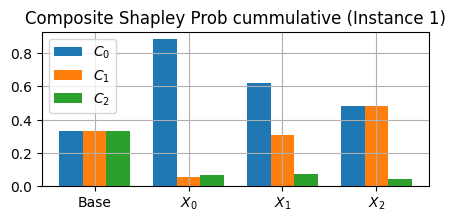

[2 1 0]


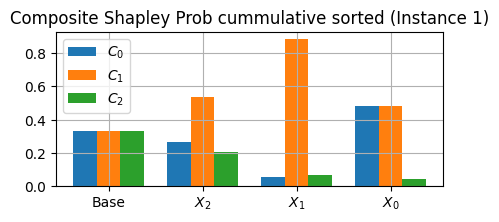

In [20]:
from numpy.linalg import norm

def plot_composite_shapley_feature_contributions(composite_shapley_values, base=None, feature_names=None, cummulative=False,
                                                 title=None, sort_by_norm=False, basis=None, fig=None, ax=None):
    """
    Parameters
    ==========
    composite_shapley_values: numpy.ndarray (n_features, n_classes-1)
    base: numpy.ndarray (n_classes-1)
        If a base is passed, the base is plot as the first step
    composite_base: numpy.ndarray (n_classes-1)
    title: string
    basis: numpy.ndarray (n_classes-1, n_classes)
        If a basis is passed, the inverse of the ILR is calculated and plot
    """
    if ax is None:
        if fig is None:
            fig = plt.figure(figsize=(5, 2))
        ax = fig.add_subplot()
        
    if title is not None:
        ax.set_title(title)
    n_features = len(composite_shapley_values)

    composite_shapley_values = np.array(composite_shapley_values).T

    if feature_names is None:
        feature_names = np.array([f"$X_{j}$" for j in range(n_features)])
    else:
        feature_names = np.array(feature_names)
      
    if sort_by_norm:
        order = np.argsort([norm(v) for v in composite_shapley_values.T])
        print(order)
        composite_shapley_values = composite_shapley_values.T[order].T
        feature_names = feature_names[order]

    if cummulative:
        composite_shapley_values = np.cumsum(composite_shapley_values, axis=1)

    if basis is not None:
        composite_shapley_values = np.array([ilr_inv(x, basis=basis) for x in composite_shapley_values.T]).T
            

    n_classes = len(composite_shapley_values[0])
    width = 1/(n_classes+1)

    if basis is not None:
        labels = [r"$C_" + str(j) + "$" for j in range(n_classes)]
    else:
        labels = [r"$\tilde{p}_" + str(j+1) + "$" for j in range(n_classes)]

    if base is not None:
        if basis is not None:
            base = ilr_inv(base, basis=basis)
        feature_names = np.concatenate([['Base',], feature_names])
        composite_shapley_values = np.hstack([base.reshape(-1, 1), composite_shapley_values])

    x = np.arange(composite_shapley_values.shape[1])
    for j, dimension in enumerate(composite_shapley_values):
        offset = width * j
        ax.bar(x + offset, dimension, width, label=labels[j])
        
    ax.set_xticks(x + width, feature_names)
    ax.legend()
    plt.show()
    return fig, ax

for space, b in {'ILR': None,
                 'Prob': basis}.items():
    for i, instance in enumerate(inst_ilr_shap_cont_list):
        fig, ax = plot_composite_shapley_feature_contributions(np.array(instance), base=base, basis=b,
                                                               title=f"Composite Shapley {space} (Instance {i})")
        fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_{i}'), dpi=300, bbox_inches='tight')
    
        fig, ax = plot_composite_shapley_feature_contributions(np.array(instance), base=base, sort_by_norm=True, basis=b,
                                                     title=f"Composite Shapley {space} sorted (Instance {i})")
        fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_sorted_{i}'), dpi=300, bbox_inches='tight')
    
        fig, ax = plot_composite_shapley_feature_contributions(np.array(instance), base=base, cummulative=True,
                                                               sort_by_norm=False, basis=b,
                                                               title=f"Composite Shapley {space} cummulative (Instance {i})")
        fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_cum_{i}'), dpi=300, bbox_inches='tight')
    
        fig, ax = plot_composite_shapley_feature_contributions(np.array(instance), base=base, cummulative=True,
                                                               sort_by_norm=True, basis=b,
                                                               title=f"Composite Shapley {space} cummulative sorted (Instance {i})")
        fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_cum_sorted_{i}'), dpi=300, bbox_inches='tight')

[[array([0.33333333, 0.33333333, 0.33333333]), array([0.03133083, 0.53008094, 0.43858824]), array([0.08354691, 0.16944275, 0.74701034]), array([0.0736245, 0.0736245, 0.852751 ])], [array([0.33333333, 0.33333333, 0.33333333]), array([0.88453197, 0.05228092, 0.0631871 ]), array([0.62308774, 0.30722506, 0.0696872 ]), array([0.47930881, 0.47930881, 0.04138239])]]
[array([0, 3, 2, 1]), array([0, 3, 2, 1])]


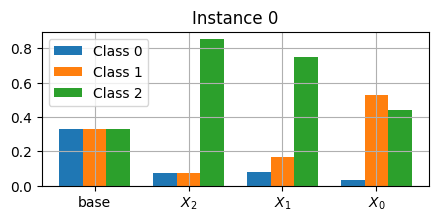

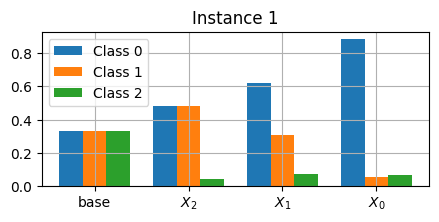

In [21]:
inst_prob_tip_with_base_list = [[base_prob, ] + inst_list for inst_list in inst_prob_tip_list]

inst_norm_order_list_with_base = [np.concatenate([[0], order_vector+1]) for order_vector in inst_norm_order_list]
print(inst_prob_tip_with_base_list)
print(inst_norm_order_list_with_base)
fig_list = plot_shapley_instances_bars(inst_prob_tip_with_base_list,
                                       feat_names=['base', ] + [f"$X_{j}$" for j in range(len(inst_prob_tip_list[0]))],
                                       order_list=inst_norm_order_list_with_base)
for i, fig in enumerate(fig_list):
    fig.savefig(os.path.join(out_dir, f'comp_shap_cum_inst_{i}'), dpi=300, bbox_inches='tight')

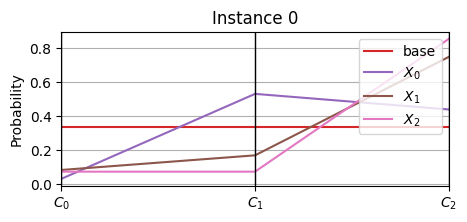

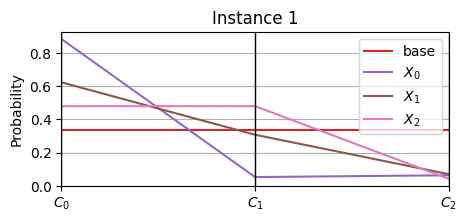

In [22]:
import pandas as pd
from pandas.plotting import parallel_coordinates

def plot_parallel_coordinates(instances_list, index, columns, colors, transpose=False):
    fig_list = []
    for i, instance_probs in enumerate(instances_list):
        df_prob_tips = pd.DataFrame(instance_probs,
                                    index=index,
                                    columns=columns)

        if transpose:
            df_prob_tips = df_prob_tips.T
        
        df_prob_tips['class'] = df_prob_tips.index
    
        fig, ax = plt.subplots(1, figsize=(5, 2))
        fig_list.append(fig)
        parallel_coordinates(df_prob_tips, class_column='class', color=colors, ax=ax)
        ax.set_title(f"Instance {i}")
        ax.grid(True)
        ax.set_ylabel('Probability')
    plt.show()
    return fig_list


def plot_parallel_coordinates_per_class(instances_list, with_base=True):

    
    if with_base:
        index = ['base', ] +[f"$X_{j}$" for j in range(len(instances_list[0])-1)]
    else:
        index = [f"$X_{j}$" for j in range(len(instances_list[0]))]

    return plot_parallel_coordinates(instances_list,
                                     index=index,
                                     columns=[f"$C_{j}$" for j in range(3)],
                                     colors=colors[3:],
                                     transpose=False)

fig_list = plot_parallel_coordinates_per_class(inst_prob_tip_with_base_list)

for i, fig in enumerate(fig_list):
    fig.savefig(os.path.join(out_dir, f'comp_shap_cum_parallel_inst_{i}'), dpi=300, bbox_inches='tight')

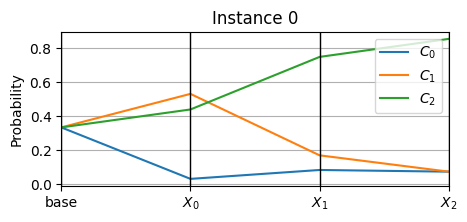

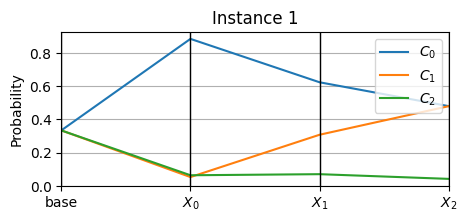

In [23]:
def plot_parallel_coordinates_per_feature(instances_list):
    return plot_parallel_coordinates(instances_list,
                                     index=['base', ] + [f"$X_{j}$" for j in range(len(instances_list[0])-1)],
                                     columns=[f"$C_{j}$" for j in range(3)],
                                     colors=colors,
                                     transpose=True)

fig_list = plot_parallel_coordinates_per_feature(inst_prob_tip_with_base_list)

for i, fig in enumerate(fig_list):
    fig.savefig(os.path.join(out_dir, f'comp_shap_cum_parallel_feat_inst_{i}'), dpi=300, bbox_inches='tight')

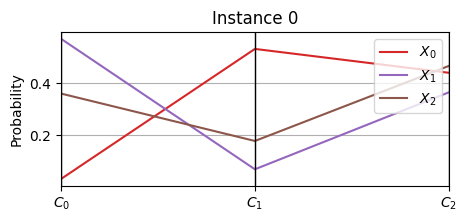

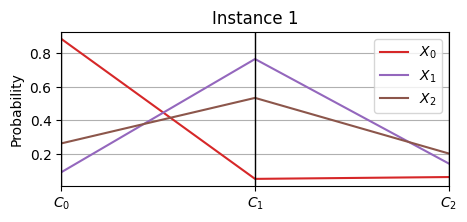

In [24]:
fig_list = plot_parallel_coordinates_per_class(inst_prob_shap_cont_list, with_base=False)

for i, fig in enumerate(fig_list):
    fig.savefig(os.path.join(out_dir, f'comp_shap_parallel_inst_{i}'), dpi=300, bbox_inches='tight')